In [2]:
from elasticsearch import Elasticsearch
import json
import requests

import eslogin

import datetime
import time

import numpy as np
from numpy.random import randn
import pandas as pd
from scipy import stats
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns

import math

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
mpl.style.use('ggplot')

In [2]:
print mpl.__version__

1.4.3


#Import data

In [3]:
clicks_uniq = pd.read_csv("../data/clicks_uniq_150610.tab",sep='\t',index_col=0,encoding='utf-8')
adShows_uniq = pd.read_csv("../data/adShows_uniq_150610.tab",sep='\t',index_col=0,encoding='utf-8')
duplicate_id = set(adShows_uniq['id']) - set(clicks_uniq['id'])
adShows_uniq_only = adShows_uniq.loc[adShows_uniq['id'].apply(lambda x: x in duplicate_id), :]

In [4]:
data = pd.concat([clicks_uniq[['ai','br','co','cty','rgn','plfm','pv','dt','sdpt','isp','ernc','dp','vw_drtn','vw_perc','cr','created_at','et']],adShows_uniq_only[['ai','br','co','cty','rgn','plfm','pv','dt','sdpt','isp','ernc','dp','vw_drtn','vw_perc','cr','created_at','et']]], axis=0)

In [5]:
def get_date(timestring):
    mytime = timestring.split('.')[0]
    return datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
data['created_at'] = data['created_at'].apply(get_date)

In [6]:
data2 = data[data['created_at'].apply(lambda x:(x.month == 5 or x.month == 6))]

In [7]:
data2['br_short'] = data2['br'].apply(lambda x:x.split()[0])
data2['click'] = data2['et'].apply(lambda x:x == 'AD_CLICK')

In [8]:
data2.shape

(18729, 19)

In [9]:
ad_type = pd.read_csv("../data/zenit_creatives_parsed.tab",sep='\t',encoding='utf-8')

In [10]:
ad_type.columns[0]

u'cr'

In [46]:
ad_type['ad_type'][ad_type['cr'].apply(lambda x: x == 157)].values[0]

u'tile_and_text'

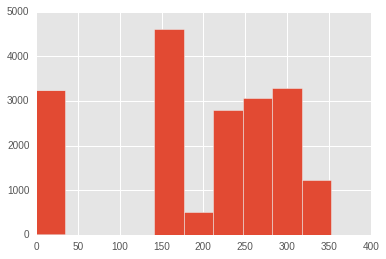

In [96]:
data2['cr'].hist()

In [97]:
data2['plfm'].value_counts()

ios        4928
android    4699
dtype: int64

In [70]:
def get_ad_type(cr_id):
    if cr_id > 0 and cr_id in ad_type['cr']:
        return ad_type['ad_type'][ad_type['cr'].apply(lambda x: x == cr_id)].values[0]
    else:
        return np.NaN
get_ad_type(157)

u'tile_and_text'

In [11]:
data2 = pd.merge(data2, ad_type, left_on ='cr', right_on ='cr', how='left')

In [12]:
data2['day'] = data2['created_at'].apply(lambda x:x.day)

In [13]:
data2['time'] = data2['created_at'].apply(lambda x:x.hour)

In [101]:
pd.options.display.max_rows = 3
pd.options.display.max_columns = 30
data2

,ai,br,co,cty,rgn,plfm,pv,dt,sdpt,isp,ernc,dp,vw_drtn,vw_perc,cr,created_at,et,br_short,click,name,ad_type,day,time
0,51,Other 0.0,GBR,Eastbourne,GBR-E2,NaN,unknown,other,1,BT,210000,300000,0,0,157,2015-05-10 04:41:11,AD_CLICK,Other,True,Anyoption #2,tile_and_text,10,4
1,NaN,Safari 10.3.1.2267,NGA,Lagos,NGA-05,NaN,unknown,other,0,Globacom Ltd,210000,300000,0,0,157,2015-05-09 06:35:35,AD_CLICK,Safari,True,Anyoption #2,tile_and_text,9,6
2,NaN,Safari 10.3.1.2558,NGA,Lagos,NGA-05,NaN,unknown,other,0,Globacom Ltd,210000,300000,0,0,157,2015-05-09 06:59:06,AD_CLICK,Safari,True,Anyoption #2,tile_and_text,9,6
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


#Specify two apps

In [110]:
features = ['click','ai','cr','br_short','co','cty','rgn','plfm','pv','dt','sdpt','isp','ernc','dp','ad_type','day','time']

In [111]:
data2_Diretta_Calcio = data2.loc[data2['ai'].apply(lambda x:(x == 67 or x == 68)),features]

In [112]:
data2_Diretta_Calcio.shape

(1163, 17)

In [229]:
800.0/1163

0.6878761822871883

In [104]:
data2_Diretta_Calcio['click'].value_counts()

True     669
False    494
dtype: int64

In [113]:
data2_Team_Manchester = data2.loc[data2['ai'].apply(lambda x:(x == 53 or x == 54)),features]

In [114]:
data2_Team_Manchester.shape

(2584, 17)

In [107]:
data2_Team_Manchester['click'].value_counts()

False    2156
True      428
dtype: int64

In [115]:
data2_Dagospia = data2.loc[data2['ai'].apply(lambda x:(x == 71 or x == 72 or x == 88)),features]

#Machine learning for Diretta Calcio

In [114]:
data2_Diretta_Calcio.index = range(data2_Diretta_Calcio.shape[0])

In [159]:
def cty_parser(city):
    if type(city) == float:
        return city
    else:
        return city.encode('ascii', 'ignore').decode('ascii')
data2_Diretta_Calcio['cty'].apply(cty_parser)

0                      Maidenhead
1                         Watford
2                        Massafra
3                             NaN
4                           Turin
5                         Palermo
6                             Rho
7                           Milan
8                             NaN
9                          Verona
10                            NaN
11                         Naples
12                            NaN
13          Giugliano In Campania
14                            NaN
15                          Padua
16                            NaN
17                         Verona
18                        Brescia
19                            NaN
20                            NaN
21                            NaN
22                           Bari
23                            NaN
24                            NaN
25                        Carrara
26                         Naples
27                            NaN
28                            NaN
29            

In [163]:
data2_Diretta_Calcio_expand = pd.concat([data2_Diretta_Calcio[['click']],pd.get_dummies(data2_Diretta_Calcio['br_short'], dummy_na=True, prefix='br'),
                                         pd.get_dummies(data2_Diretta_Calcio['co'], dummy_na=True, prefix='co'),
                                         pd.get_dummies(data2_Diretta_Calcio['cty'].apply(cty_parser), dummy_na=True, prefix='cty'),
                                         pd.get_dummies(data2_Diretta_Calcio['rgn'], dummy_na=True, prefix='rgn'),
                                         pd.get_dummies(data2_Diretta_Calcio['plfm'], dummy_na=True, prefix='plfm'),
                                         pd.get_dummies(data2_Diretta_Calcio['pv'], dummy_na=True, prefix='pv'),
                                         pd.get_dummies(data2_Diretta_Calcio['dt'], dummy_na=True, prefix='dt'),
                                         pd.get_dummies(data2_Diretta_Calcio['isp'], dummy_na=True, prefix='isp'),
                                         pd.get_dummies(data2_Diretta_Calcio['ad_type'], dummy_na=True, prefix='ad_type'),
                                         data2_Diretta_Calcio[['ai','sdpt','day','time','ernc','dp']]],axis=1)

In [165]:
data2_Diretta_Calcio_expand.shape

(1163, 370)

In [173]:
train_Diretta_Calcio_Ind = np.random.choice(data2_Diretta_Calcio.shape[0], size=800, replace=False)

In [175]:
train_Diretta_Calcio = data2_Diretta_Calcio_expand.loc[train_Diretta_Calcio_Ind,:]

In [176]:
test_Diretta_Calcio_Ind = []
for i in range(data2_Diretta_Calcio.shape[0]):
    if not i in train_Diretta_Calcio_Ind:
        test_Diretta_Calcio_Ind.append(i)
len(test_Diretta_Calcio_Ind)

363

In [177]:
test_Diretta_Calcio = data2_Diretta_Calcio_expand.loc[test_Diretta_Calcio_Ind,:]

In [178]:
test_Diretta_Calcio

click  br_Android  br_Chrome  br_Opera  br_Other  br_nan  co_BEL  co_CAN  \
5   True           0          1         0         0       0       0       0   
6   True           0          1         0         0       0       0       0   
15  True           1          0         0         0       0       0       0   
     ...         ...        ...       ...       ...     ...     ...     ...   

    co_DEU  co_ESP  co_FRA  co_GBR  co_ITA  co_MAR  co_NGA  co_SAU  co_USA  \
5        0       0       0       0       1       0       0       0       0   
6        0       0       0       0       1       0       0       0       0   
15       0       0       0       0       1       0       0       0       0   
       ...     ...     ...     ...     ...     ...     ...     ...     ...   

    co_nan  cty_Acerra  cty_Adelfia  cty_Agropoli  cty_Albenga  cty_Albino  \
5        0           0            0             0            0           0   
6        0           0            0             0            0           0   
15       0           0            0             0            0           0   
       ...         ...          ...           ...          ...         ...   

    cty_Alessandria  cty_Alghero  cty_Almenno San Salvatore  cty_Altamura  \
5                 0            0                          0             0   
6                 0            0                          0             0   
15                0            0                          0             0   
                ...          ...                        ...           ...   

    cty_Alzano Lombardo  cty_Amelia  cty_Ancona      
5                     0           0           0 ...  
6                     0           0           0 ...  
15                    0           0           0 ...  
                    ...         ...         ...      

[363 rows x 370 columns]

In [179]:
train_Diretta_Calcio_data = train_Diretta_Calcio.values

In [180]:
forest = RandomForestClassifier(n_estimators = 100)

In [181]:
forest_Diretta_Calcio = forest.fit(train_Diretta_Calcio_data[0::,1::],train_Diretta_Calcio_data[0::,0])

In [182]:
test_Diretta_Calcio_data = test_Diretta_Calcio.values

In [183]:
predict_Diretta_Calcio = forest.predict(test_Diretta_Calcio_data[0::,1::])

In [190]:
def error_analysis(predict, reality):
    accuracy = float(np.sum(predict == reality))/len(reality) * 100
    precision = float(np.sum((reality == 1)*(reality == predict)))/np.sum(predict == 1) * 100
    recall = float(np.sum((reality == 1)*(reality == predict)))/np.sum(reality == 1) * 100
    f1score = 2*precision*recall/(precision + recall)/100
    print 'accuracy:%.2f\nprecision:%.2f\nrecall:%.2f\nF1 score:%.2f' % (accuracy, precision, recall, f1score)
error_analysis(predict_Diretta_Calcio, test_Diretta_Calcio_data[0::,0])

accuracy:95.87
precision:95.75
recall:97.13
F1 score:0.96


In [191]:
predict_Diretta_Calcio_train = forest.predict(train_Diretta_Calcio_data[0::,1::])

In [192]:
error_analysis(predict_Diretta_Calcio_train, train_Diretta_Calcio_data[0::,0])

accuracy:99.75
precision:100.00
recall:99.57
F1 score:1.00


# Feature importance for Diretta Calcio

In [194]:
importances_Diretta_Calcio = forest_Diretta_Calcio.feature_importances_
std_Diretta_Calcio = np.std([tree.feature_importances_ for tree in forest_Diretta_Calcio.estimators_],axis=0)
indices_Diretta_Calcio = np.argsort(importances_Diretta_Calcio)[::-1]

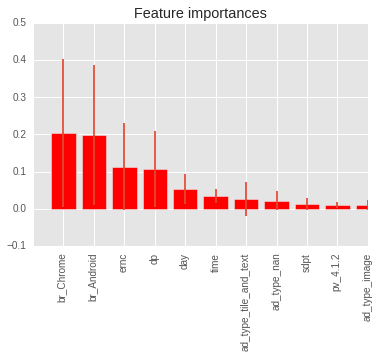

In [200]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances_Diretta_Calcio)), importances_Diretta_Calcio[indices_Diretta_Calcio],
       color="r", yerr=std_Diretta_Calcio[indices_Diretta_Calcio], align="center")
plt.xticks(range(len(importances_Diretta_Calcio)), train_Diretta_Calcio.columns[1:][indices_Diretta_Calcio],
           rotation='vertical')
plt.xlim([-1, 10])
plt.show()

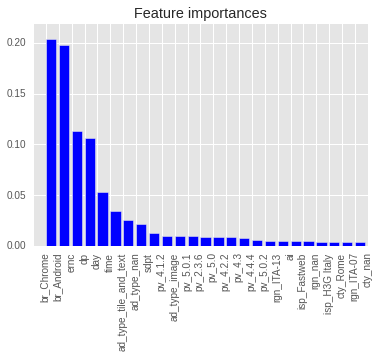

In [242]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances_Diretta_Calcio)), importances_Diretta_Calcio[indices_Diretta_Calcio],color="b")
plt.xticks(range(len(importances_Diretta_Calcio)), train_Diretta_Calcio.columns[1:][indices_Diretta_Calcio],
           rotation='vertical')
plt.xlim([-1, 25])
plt.ylim([0, 0.22])
plt.savefig("../fig/20150614_RF_feature_top_25_Diretta_Calcio.png",format='png')

^browser type plays essential role!

In [203]:
features_Diretta_Calcio = pd.DataFrame({'feature': train_Diretta_Calcio.columns.values[1:],
                                        'importance': importances_Diretta_Calcio,
                                        'type': [x.split('_')[0] for x in train_Diretta_Calcio.columns.values[1:]]},
                                       index = range(len(importances_Diretta_Calcio)))

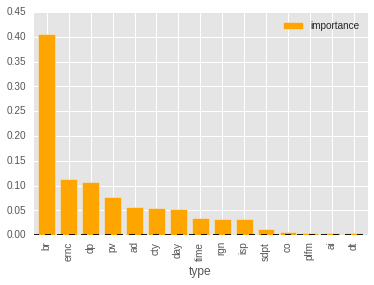

In [205]:
p = features_Diretta_Calcio[['type',
                             'importance']].groupby('type').sum().sort('importance',
                                                                       ascending = 0).plot(kind='bar',
                                                                                           color='orange')
fig = p.get_figure()
fig.savefig('../fig/20150614_RF_feature_sum_Diretta_Calcio.png',format='png')

In [208]:
rate_Diretta_Calcio = float(data2_Diretta_Calcio.click.sum())/data2_Diretta_Calcio.shape[0]
rate_Diretta_Calcio

0.5752364574376613

In [210]:
br_ctr_Diretta_Calcio = data2_Diretta_Calcio.groupby('br_short').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Diretta_Calcio).apply(lambda x: np.log2(x+0.001))
br_ctr_Diretta_Calcio.sort(ascending = False)
br_ctr_Diretta_Calcio

br_short
Opera       0.798603
Chrome      0.798603
Other      -0.200568
...
Opera       0.798603
Chrome      0.798603
Other      -0.200568
Android    -1.530531
Length: 4, dtype: float64

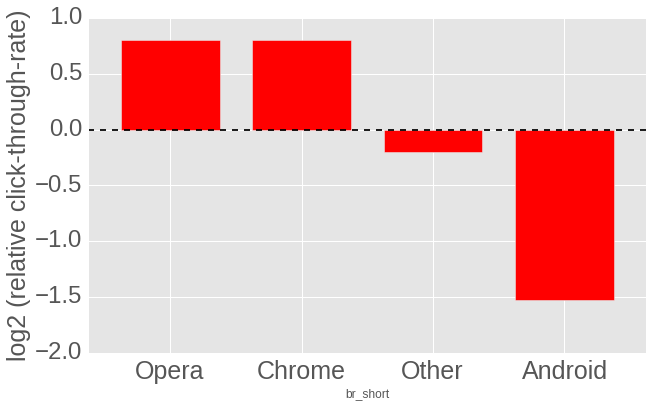

In [217]:
plt.figure(figsize=(10,6))
p = br_ctr_Diretta_Calcio.plot(kind='bar',color='r')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='horizontal', fontsize=25)
plt.setp(p.get_yticklabels(), fontsize=24)
fig = p.get_figure()
fig.savefig('../fig/20150614_CTR_by_br_sort_Diretta_Calcio.png',format='png')

Although Android wins overall, it shows opposite trend for this specific app - interesting...

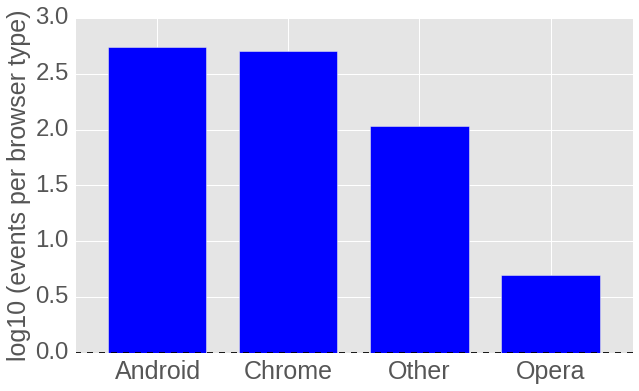

In [219]:
br_counts_Diretta_Calcio = data2_Diretta_Calcio['br_short'].value_counts()
plt.figure(figsize=(10,6))
p = np.log10(br_counts_Diretta_Calcio[br_counts_Diretta_Calcio.index]).plot(kind='bar',color='b')
p.set_ylabel('log10 (events per browser type)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='horizontal', fontsize=25)
plt.setp(p.get_yticklabels(), fontsize=24)
#plt.gca().invert_yaxis()
fig = p.get_figure()
fig.savefig('../fig/20150614_et_by_br_sort_Diretta_Calcio.png',format='png')

Not many cases in Opera. Chrome beats Android here.

Just want to confirm a bit:

In [225]:
data2_Diretta_Calcio['click'][data2_Diretta_Calcio['br_short'] == 'Android'].value_counts()

False    440
True     109
dtype: int64

In [339]:
data2_Diretta_Calcio['co'].value_counts()

ITA    1128
USA      18
GBR       5
BEL       3
DEU       3
MAR       1
ESP       1
FRA       1
SAU       1
CAN       1
...
ITA    1128
USA      18
GBR       5
BEL       3
DEU       3
MAR       1
ESP       1
FRA       1
SAU       1
CAN       1
NGA       1
Length: 11, dtype: int64

It's dominate Italy - that's why ITA associated with higher CTR?

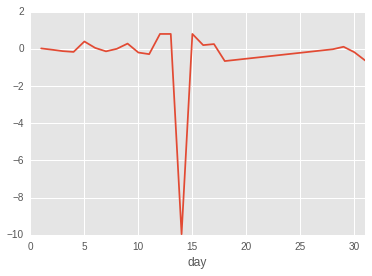

In [278]:
data2_Diretta_Calcio.groupby('day').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Diretta_Calcio).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(0,31))

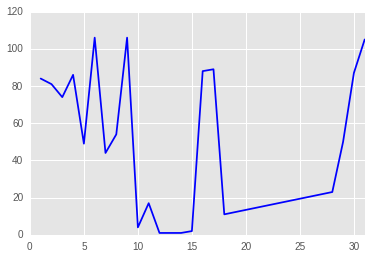

In [279]:
data2_Diretta_Calcio['day'].value_counts().sort_index().plot(color="b",xlim=(0,31))

The date of each month is not important for CTR

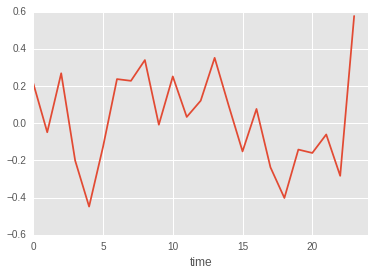

In [281]:
data2_Diretta_Calcio.groupby('time').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Diretta_Calcio).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(0,24))

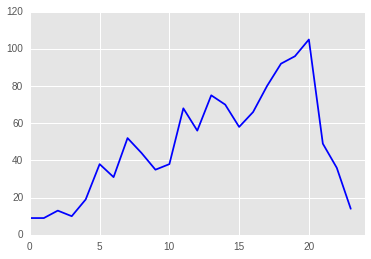

In [282]:
data2_Diretta_Calcio['time'].value_counts().sort_index().plot(color="b",xlim=(0,24))

More ads should be released at 6am-1pm (morning) or around midnight? - or anti-correlated?

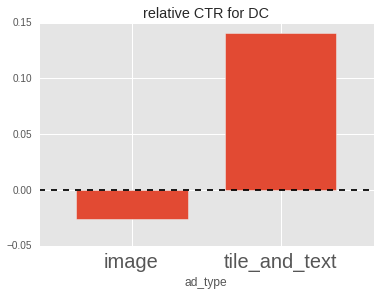

In [353]:
data2_Diretta_Calcio.groupby('ad_type').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Diretta_Calcio).apply(lambda x: np.log2(x+0.001)).sort_index().plot(kind='bar',rot='horizontal',fontsize=20, title='relative CTR for DC')

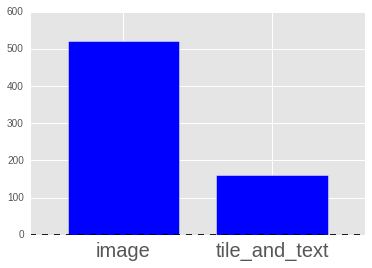

In [298]:
data2_Diretta_Calcio['ad_type'].value_counts().plot(kind='bar',rot='horizontal',fontsize=20,color="b")

In [320]:
breaks = range(0,120,2)
sdpt_ctr_Diretta_Calcio = []
for i in breaks:
    sdpt_ctr_Diretta_Calcio.append(float(data2_Diretta_Calcio[data2_Diretta_Calcio['sdpt'].apply(lambda x:x < i)].click.sum())/(data2_Diretta_Calcio[data2_Diretta_Calcio['sdpt'].apply(lambda x:x < i)].shape[0] + 0.001))

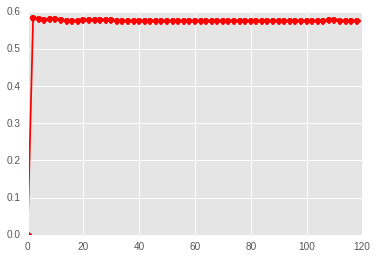

In [321]:
plt.plot(breaks, sdpt_ctr_Diretta_Calcio, 'ro-')

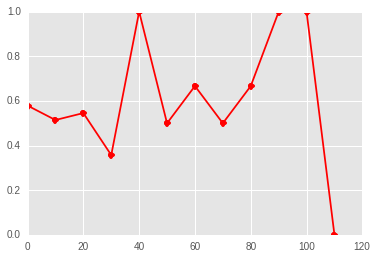

In [324]:
step = 10
breaks = range(0,120,step)
sdpt_ctr_Diretta_Calcio = []
for i in breaks:
    sdpt_ctr_Diretta_Calcio.append(float(data2_Diretta_Calcio[data2_Diretta_Calcio['sdpt'].apply(lambda x:(x >= i and x < i + step))].click.sum())/(data2_Diretta_Calcio[data2_Diretta_Calcio['sdpt'].apply(lambda x:(x >= i and x < i + step))].shape[0] + 0.001))
plt.plot(breaks, sdpt_ctr_Diretta_Calcio, 'ro-')

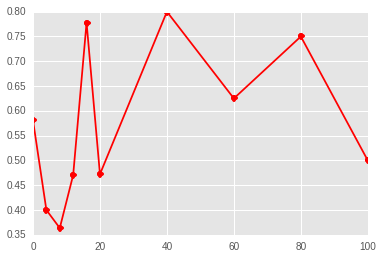

In [328]:
step1 = 4
step2 = 20
breaks1 = range(0,20,step1)
breaks2 = range(20,120,step2)
sdpt_ctr_Diretta_Calcio = []
for i in breaks1:
    sdpt_ctr_Diretta_Calcio.append(float(data2_Diretta_Calcio[data2_Diretta_Calcio['sdpt'].apply(lambda x:(x >= i and x < i + step1))].click.sum())/(data2_Diretta_Calcio[data2_Diretta_Calcio['sdpt'].apply(lambda x:(x >= i and x < i + step1))].shape[0] + 0.001))
for i in breaks2:
    sdpt_ctr_Diretta_Calcio.append(float(data2_Diretta_Calcio[data2_Diretta_Calcio['sdpt'].apply(lambda x:(x >= i and x < i + step2))].click.sum())/(data2_Diretta_Calcio[data2_Diretta_Calcio['sdpt'].apply(lambda x:(x >= i and x < i + step2))].shape[0] + 0.001))
breaks = breaks1 + breaks2
plt.plot(breaks, sdpt_ctr_Diretta_Calcio, 'ro-')

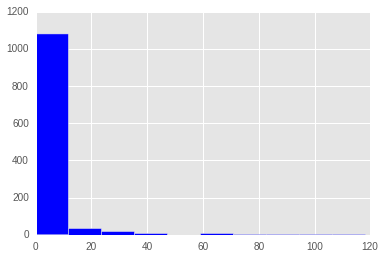

In [319]:
data2_Diretta_Calcio['sdpt'].hist(color="b")

There's no obvious "trend" for sdpt here

#Machine learning for Team Manchester

In [226]:
data2_Team_Manchester.index = range(data2_Team_Manchester.shape[0])

In [227]:
data2_Team_Manchester_expand = pd.concat([data2_Team_Manchester[['click']],
                                         pd.get_dummies(data2_Team_Manchester['br_short'], dummy_na=True, prefix='br'),
                                         pd.get_dummies(data2_Team_Manchester['co'], dummy_na=True, prefix='co'),
                                         pd.get_dummies(data2_Team_Manchester['cty'].apply(cty_parser), dummy_na=True, prefix='cty'),
                                         pd.get_dummies(data2_Team_Manchester['rgn'], dummy_na=True, prefix='rgn'),
                                         pd.get_dummies(data2_Team_Manchester['plfm'], dummy_na=True, prefix='plfm'),
                                         pd.get_dummies(data2_Team_Manchester['pv'], dummy_na=True, prefix='pv'),
                                         pd.get_dummies(data2_Team_Manchester['dt'], dummy_na=True, prefix='dt'),
                                         pd.get_dummies(data2_Team_Manchester['isp'], dummy_na=True, prefix='isp'),
                                         pd.get_dummies(data2_Team_Manchester['ad_type'], dummy_na=True, prefix='ad_type'),
                                         data2_Team_Manchester[['ai','sdpt','day','time','ernc','dp']]],axis=1)

In [230]:
data2_Team_Manchester_expand.shape

(2584, 1504)

In [231]:
2584.0 * 0.7

1808.8

In [232]:
train_Team_Manchester_Ind = np.random.choice(data2_Team_Manchester.shape[0], size=1800, replace=False)

In [233]:
test_Team_Manchester_Ind = []
for i in range(data2_Team_Manchester.shape[0]):
    if not i in train_Team_Manchester_Ind:
        test_Team_Manchester_Ind.append(i)
len(test_Team_Manchester_Ind)

784

In [234]:
train_Team_Manchester = data2_Team_Manchester_expand.loc[train_Team_Manchester_Ind,:]
test_Team_Manchester = data2_Team_Manchester_expand.loc[test_Team_Manchester_Ind,:]

In [235]:
train_Team_Manchester_data = train_Team_Manchester.values
test_Team_Manchester_data = test_Team_Manchester.values

In [236]:
forest = RandomForestClassifier(n_estimators = 100)
forest_Team_Manchester = forest.fit(train_Team_Manchester_data[0::,1::],train_Team_Manchester_data[0::,0])
predict_Team_Manchester_train = forest.predict(train_Team_Manchester_data[0::,1::])
predict_Team_Manchester_test = forest.predict(test_Team_Manchester_data[0::,1::])

In [237]:
error_analysis(predict_Team_Manchester_train, train_Team_Manchester_data[0::,0])

accuracy:99.94
precision:100.00
recall:99.64
F1 score:1.00


In [238]:
error_analysis(predict_Team_Manchester_test, test_Team_Manchester_data[0::,0])

accuracy:90.94
precision:100.00
recall:52.98
F1 score:0.69


#Feature importance for Team Manchester

In [239]:
importances_Team_Manchester = forest_Team_Manchester.feature_importances_
std_Team_Manchester = np.std([tree.feature_importances_ for tree in forest_Team_Manchester.estimators_],axis=0)
indices_Team_Manchester = np.argsort(importances_Team_Manchester)[::-1]

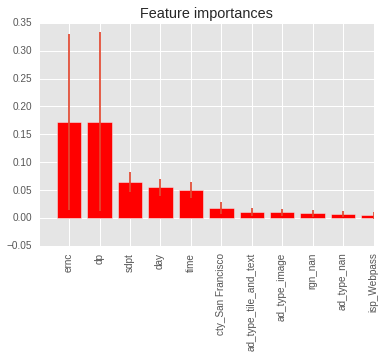

In [240]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances_Team_Manchester)), importances_Team_Manchester[indices_Team_Manchester],
       color="r", yerr=std_Team_Manchester[indices_Team_Manchester], align="center")
plt.xticks(range(len(importances_Team_Manchester)), train_Team_Manchester.columns[1:][indices_Team_Manchester],
           rotation='vertical')
plt.xlim([-1, 10])
plt.show()

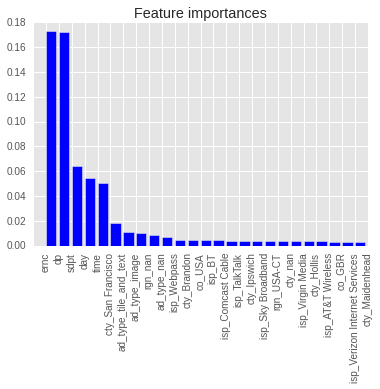

In [244]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances_Team_Manchester)), importances_Team_Manchester[indices_Team_Manchester],color="b")
plt.xticks(range(len(importances_Team_Manchester)), train_Team_Manchester.columns[1:][indices_Team_Manchester],
           rotation='vertical')
plt.xlim([-1, 25])
plt.ylim([0, 0.18])
plt.savefig("../fig/20150614_RF_feature_top_25_Team_Manchester.png",format='png')

In [245]:
features_Team_Manchester = pd.DataFrame({'feature': train_Team_Manchester.columns.values[1:],
                                    'importance': importances_Team_Manchester,
                                    'type': [x.split('_')[0] for x in train_Team_Manchester.columns.values[1:]]},
                                    index = range(len(importances_Team_Manchester)))

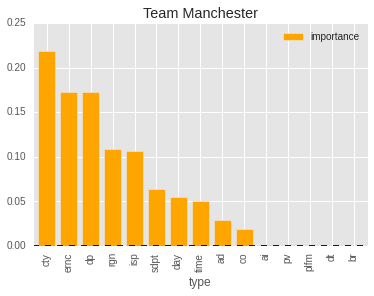

In [352]:
p = features_Team_Manchester[['type',
                             'importance']].groupby('type').sum().sort('importance',
                                                                       ascending = 0).plot(kind='bar',
                                                                                           color='orange',
                                                                                          title='Team Manchester')
fig = p.get_figure()
fig.savefig('../fig/20150614_RF_feature_sum_Team_Manchester.png',format='png')

In [247]:
data2_Team_Manchester['br_short'].value_counts()

Other       2583
Internet       1
dtype: int64

"browser" is not informative for the case here. Geo, time, and other features seem to be more important.

In [248]:
rate_Team_Manchester = float(data2_Team_Manchester.click.sum())/data2_Team_Manchester.shape[0]
rate_Team_Manchester

0.16563467492260062

CTR is also much lower than Diretta Calcio

In [252]:
ctr_cty_Team_Manchester = data2_Team_Manchester.groupby('cty').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Team_Manchester).apply(lambda x: np.log2(x+0.001))

In [254]:
ctr_cty_Team_Manchester.sort(ascending = False)

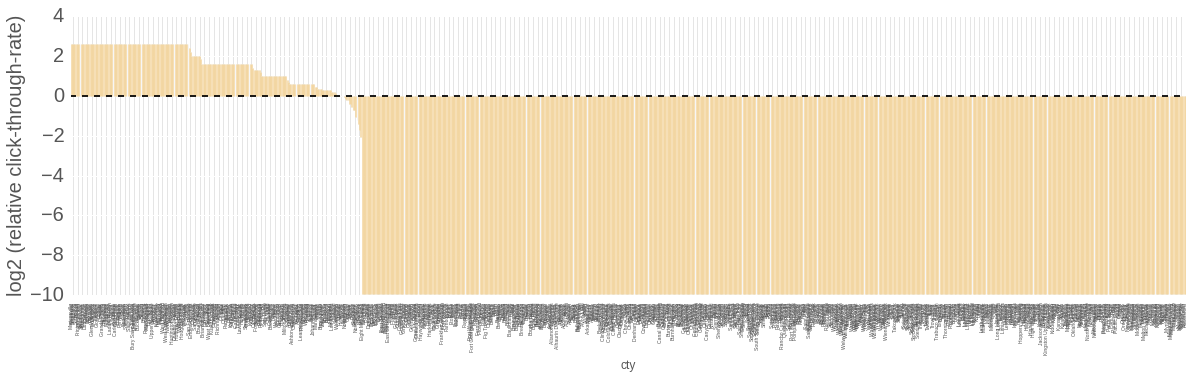

In [257]:
plt.figure(figsize=(20,5))
p = ctr_cty_Team_Manchester.plot(kind='bar',color='orange')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=5)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150614_CTR_by_cty_Team_Manchester.png',format='png')

A few cities show higher CTR and most show lower than average CTR

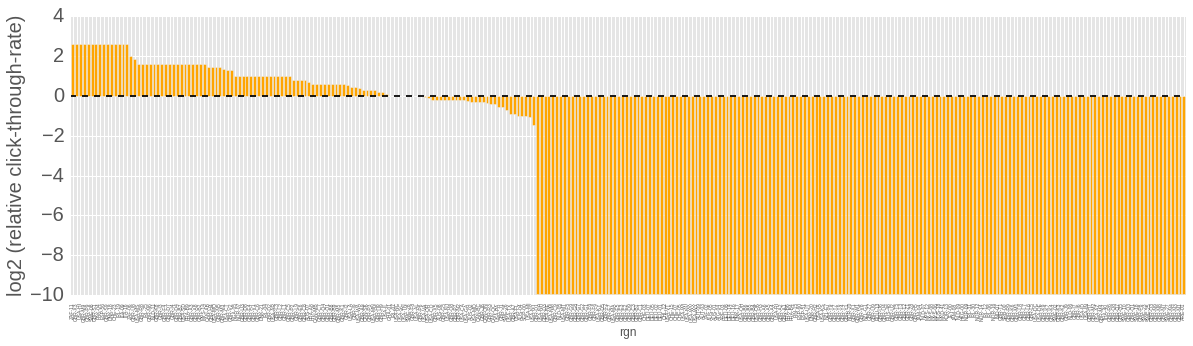

In [258]:
ctr_rgn_Team_Manchester = data2_Team_Manchester.groupby('rgn').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Team_Manchester).apply(lambda x: np.log2(x+0.001))
ctr_rgn_Team_Manchester.sort(ascending = False)
plt.figure(figsize=(20,5))
p = ctr_rgn_Team_Manchester.plot(kind='bar',color='orange')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=5)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150614_CTR_by_rgn_Team_Manchester.png',format='png')

In [340]:
data2_Team_Manchester['co'].value_counts()

GBR    994
USA    911
SGP    149
AUS    144
CAN    110
IRL     47
SWE     45
NOR     20
NGA     18
DEU     16
ZAF     14
NZL     13
DNK     12
CHE     12
GHA     11
NLD     11
FRA      9
MYS      7
ESP      4
HKG      3
MUS      3
AUT      3
ARE      2
KOR      2
ITA      2
JPN      2
JAM      2
FIN      1
PAK      1
IRQ      1
MKD      1
CHL      1
ATG      1
THA      1
JEY      1
UGA      1
SRB      1
ROU      1
IND      1
...
GBR    994
USA    911
SGP    149
AUS    144
CAN    110
IRL     47
SWE     45
NOR     20
NGA     18
DEU     16
ZAF     14
NZL     13
DNK     12
CHE     12
GHA     11
NLD     11
FRA      9
MYS      7
ESP      4
HKG      3
MUS      3
AUT      3
ARE      2
KOR      2
ITA      2
JPN      2
JAM      2
FIN      1
PAK      1
IRQ      1
MKD      1
CHL      1
ATG      1
THA      1
JEY      1
UGA      1
SRB      1
ROU      1
IND      1
RUS      1
Length: 40, dtype: int64

This app is more global

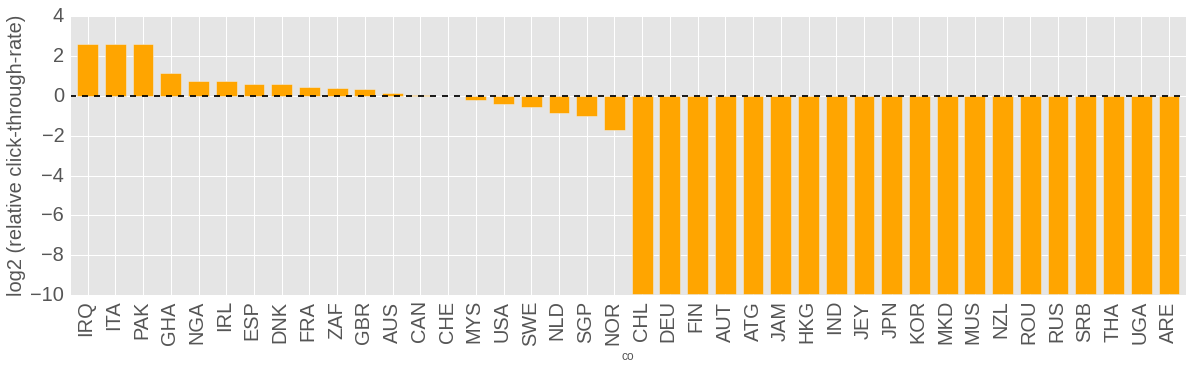

In [342]:
ctr_co_Team_Manchester = data2_Team_Manchester.groupby('co').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Team_Manchester).apply(lambda x: np.log2(x+0.001))
ctr_co_Team_Manchester.sort(ascending = False)
plt.figure(figsize=(20,5))
p = ctr_co_Team_Manchester.plot(kind='bar',color='orange')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=20)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150614_CTR_by_co_Team_Manchester.png',format='png')

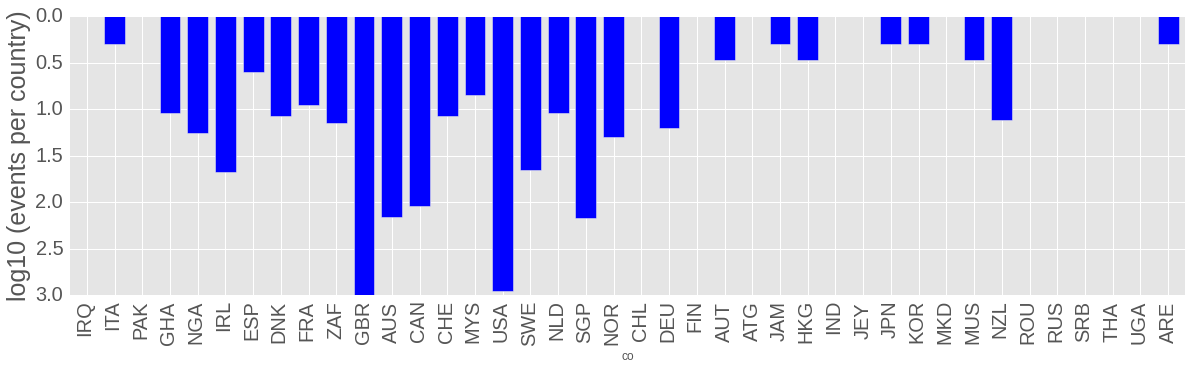

In [344]:
co_counts_Team_Manchester = data2_Team_Manchester['co'].value_counts()
plt.figure(figsize=(20,5))
p = np.log10(co_counts_Team_Manchester[ctr_co_Team_Manchester.index]).plot(kind='bar',color='b')
p.set_ylabel('log10 (events per country)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=20)
plt.setp(p.get_yticklabels(), fontsize=20)
plt.gca().invert_yaxis()
fig = p.get_figure()
fig.savefig('../fig/20150614_et_by_co_Team_Manchester.png',format='png')

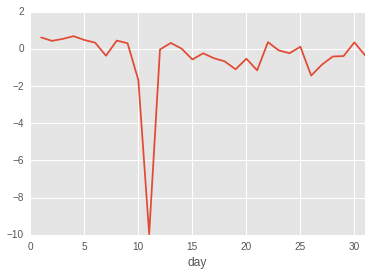

In [275]:
data2_Team_Manchester.groupby('day').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Team_Manchester).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(0,31))

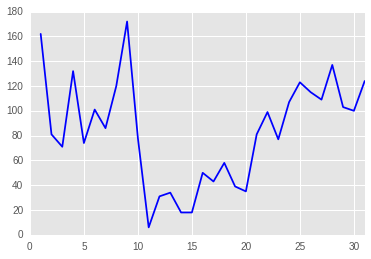

In [271]:
data2_Team_Manchester['day'].value_counts().sort_index().plot(color="b",xlim=(0,31))

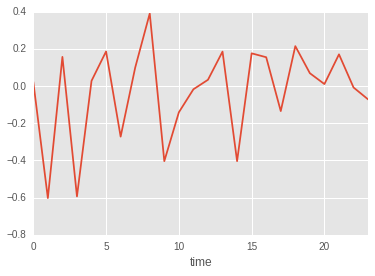

In [276]:
data2_Team_Manchester.groupby('time').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Team_Manchester).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(0,23))

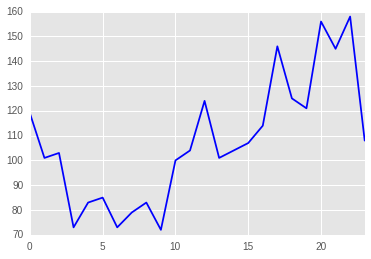

In [277]:
data2_Team_Manchester['time'].value_counts().sort_index().plot(color="b",xlim=(0,23))

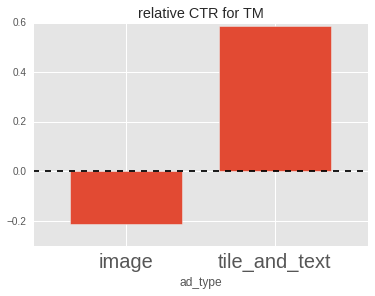

In [354]:
data2_Team_Manchester.groupby('ad_type').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Team_Manchester).apply(lambda x: np.log2(x+0.001)).sort_index().plot(kind='bar',rot='horizontal',fontsize=20, title='relative CTR for TM')

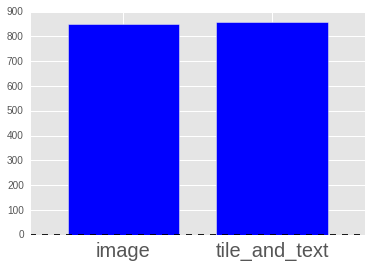

In [303]:
data2_Team_Manchester['ad_type'].value_counts().sort_index().plot(kind='bar',rot='horizontal',fontsize=20,color="b")

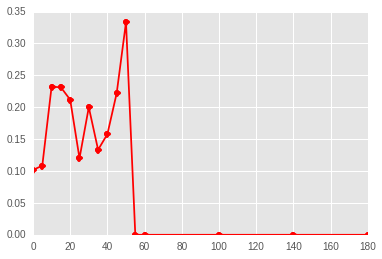

In [336]:
step1 = 5
step2 = 40
breaks1 = range(0,60,step1)
breaks2 = range(60,200,step2)
sdpt_ctr_Team_Manchester = []
for i in breaks1:
    sdpt_ctr_Team_Manchester.append(float(data2_Team_Manchester[data2_Team_Manchester['sdpt'].apply(lambda x:(x >= i and x < i + step1))].click.sum())/(data2_Team_Manchester[data2_Team_Manchester['sdpt'].apply(lambda x:(x >= i and x < i + step1))].shape[0] + 0.001))
for i in breaks2:
    sdpt_ctr_Team_Manchester.append(float(data2_Team_Manchester[data2_Team_Manchester['sdpt'].apply(lambda x:(x >= i and x < i + step2))].click.sum())/(data2_Team_Manchester[data2_Team_Manchester['sdpt'].apply(lambda x:(x >= i and x < i + step2))].shape[0] + 0.001))
breaks = breaks1 + breaks2
plt.plot(breaks, sdpt_ctr_Team_Manchester, 'ro-')

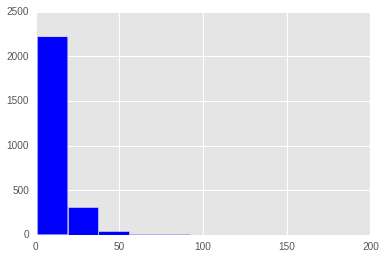

In [318]:
data2_Team_Manchester['sdpt'].hist(color="b")

Maybe sdpt < 50?

#All apps

In [283]:
rate = float(data2.click.sum())/data2.shape[0]
rate

0.2874686315339847

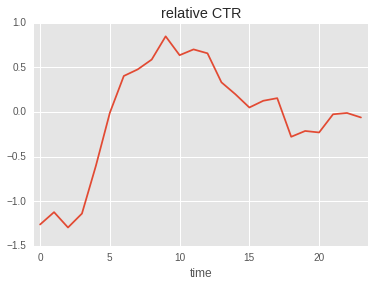

In [350]:
data2.groupby('time').apply(lambda x:float(x.click.sum())/x.shape[0]/rate).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(-.5,23.5), title='relative CTR')

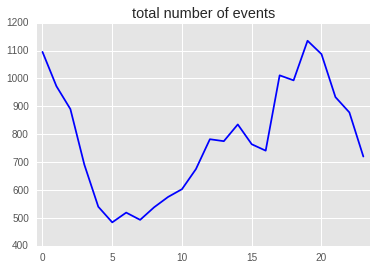

In [349]:
data2['time'].value_counts().sort_index().plot(color="b",xlim=(-.5,23.5), title='total number of events')

Overall, there's anti-corelation between the amount of events and CTR..

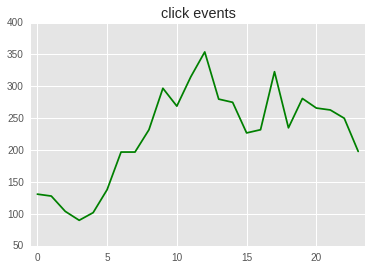

In [351]:
data2['time'][data2['click']].value_counts().sort_index().plot(color="g",xlim=(-.5,23.5), title='click events')

timestamp here are all in UTC

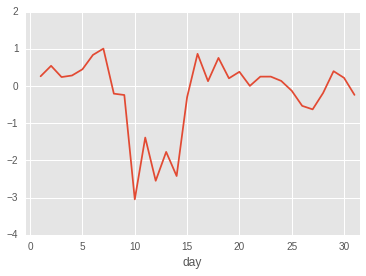

In [290]:
data2.groupby('day').apply(lambda x:float(x.click.sum())/x.shape[0]/rate).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(-.5,31.5))

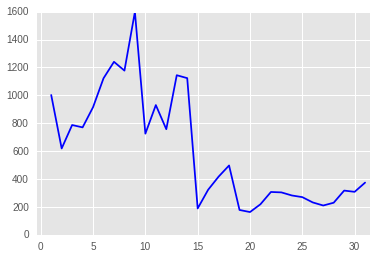

In [291]:
data2['day'].value_counts().sort_index().plot(color="b",xlim=(-.5,31.5))

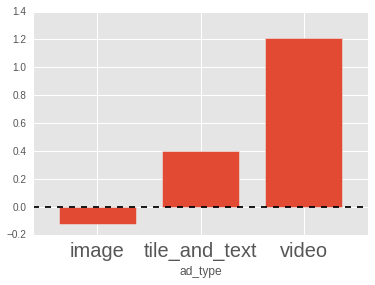

In [304]:
data2.groupby('ad_type').apply(lambda x:float(x.click.sum())/x.shape[0]/rate).apply(lambda x: np.log2(x+0.001)).sort_index().plot(kind='bar',rot='horizontal',fontsize=20)

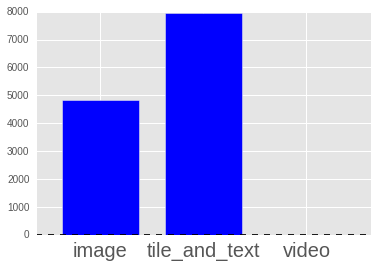

In [308]:
data2['ad_type'].value_counts().sort_index().plot(kind='bar',rot='horizontal',fontsize=20,color="b",logy=True)

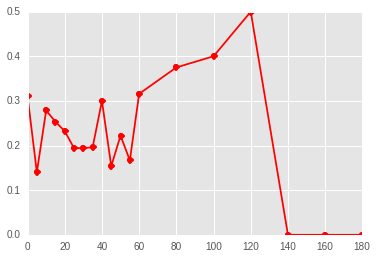

In [338]:
step1 = 5
step2 = 20
breaks1 = range(0,60,step1)
breaks2 = range(60,200,step2)
sdpt_ctr = []
for i in breaks1:
    sdpt_ctr.append(float(data2[data2['sdpt'].apply(lambda x:(x >= i and x < i + step1))].click.sum())/(data2[data2['sdpt'].apply(lambda x:(x >= i and x < i + step1))].shape[0] + 0.001))
for i in breaks2:
    sdpt_ctr.append(float(data2[data2['sdpt'].apply(lambda x:(x >= i and x < i + step2))].click.sum())/(data2[data2['sdpt'].apply(lambda x:(x >= i and x < i + step2))].shape[0] + 0.001))
breaks = breaks1 + breaks2
plt.plot(breaks, sdpt_ctr, 'ro-')

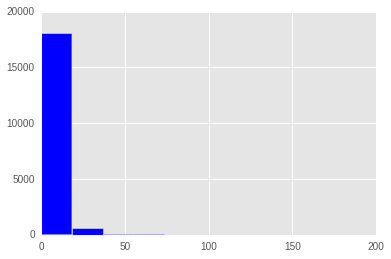

In [317]:
data2['sdpt'].hist(color="b")

Pattern for all data is different from the previous two apps

# Correct for uneven sampling

In [96]:
impression_sample_rate = float(19872)/4584942
impression_sample_rate

0.004334187869770217

In [97]:
rate = float(data2.click.sum())/((~data2.click).sum()/impression_sample_rate + data2.click.sum())
rate

0.0017455627064941754

In [117]:
rate_Diretta_Calcio = float(data2_Diretta_Calcio.click.sum())/((~data2_Diretta_Calcio.click).sum()/impression_sample_rate + data2_Diretta_Calcio.click.sum())
rate_Diretta_Calcio

0.0058353273983402136

In [118]:
rate_Team_Manchester = float(data2_Team_Manchester.click.sum())/((~data2_Team_Manchester.click).sum()/impression_sample_rate + data2_Team_Manchester.click.sum())
rate_Team_Manchester

0.00085966498230947183

In [108]:
rate_Dagospia = float(data2_Dagospia.click.sum())/((~data2_Dagospia.click).sum()/impression_sample_rate + data2_Dagospia.click.sum())
rate_Dagospia

0.005703706238003905

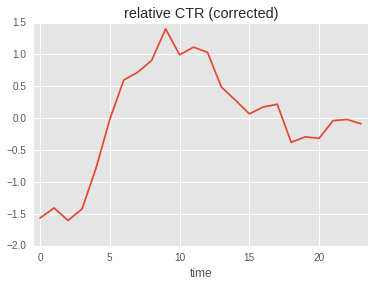

In [363]:
data2.groupby('time').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())/rate).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(-.5,23.5), title='relative CTR (corrected)')

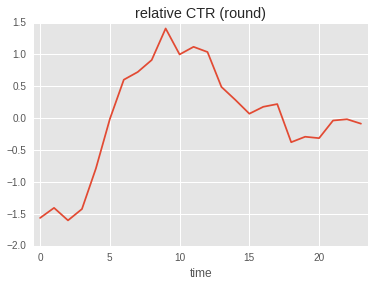

In [365]:
data2.groupby('time').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate)/rate).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(-.5,23.5), title='relative CTR (round)')

Well the shape looks pretty similar with the old plot, but just the "amplitude" changes

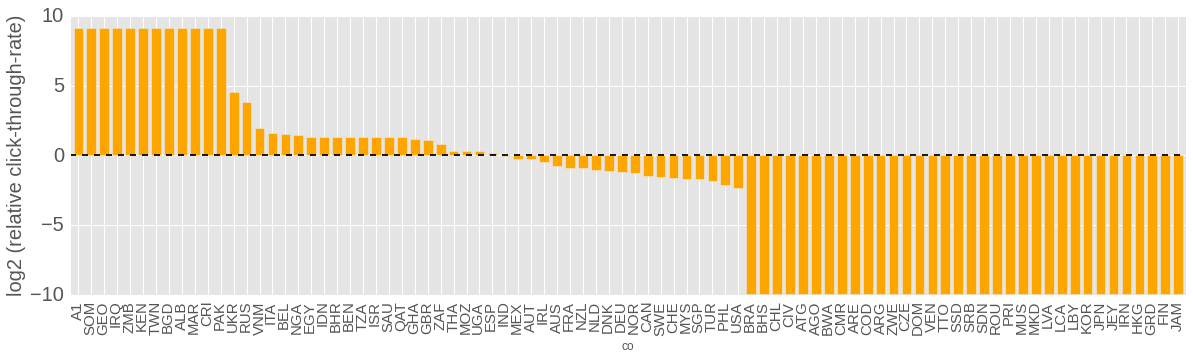

In [364]:
co_ctr = data2.groupby('co').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())/rate).apply(lambda x: np.log2(x+0.001))
co_ctr.sort(ascending = False)
plt.figure(figsize=(20,5))
p = co_ctr.plot(kind='bar',color='orange')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=15)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150615_CTR_by_co_sort_corrected.png',format='png')

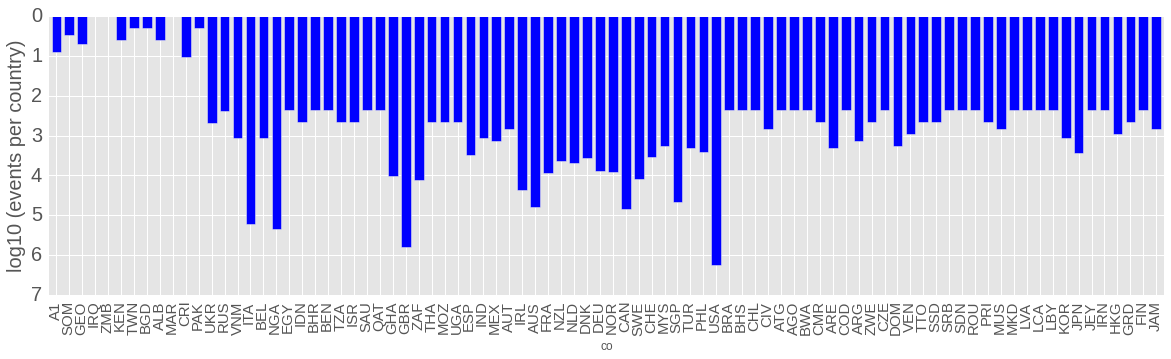

In [371]:
co_counts = data2.groupby('co').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate))
plt.figure(figsize=(20,5))
p = np.log10(co_counts[co_ctr.index]).plot(kind='bar',color='b')
p.set_ylabel('log10 (events per country)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=15)
plt.setp(p.get_yticklabels(), fontsize=20)
plt.gca().invert_yaxis()
fig = p.get_figure()
fig.savefig('../fig/20150615_et_by_co_sort_corrected.png',format='png')

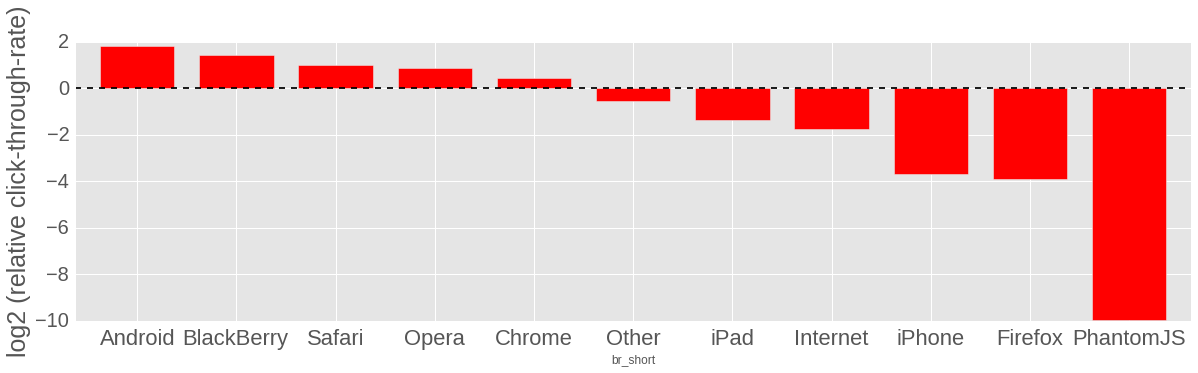

In [375]:
br_ctr = data2.groupby('br_short').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())/rate).apply(lambda x: np.log2(x+0.001))
br_ctr.sort(ascending = False)
plt.figure(figsize=(20,5))
p = br_ctr.plot(kind='bar',color='r')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='horizontal', fontsize=22)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150615_CTR_by_br_sort_corrected.png',format='png')

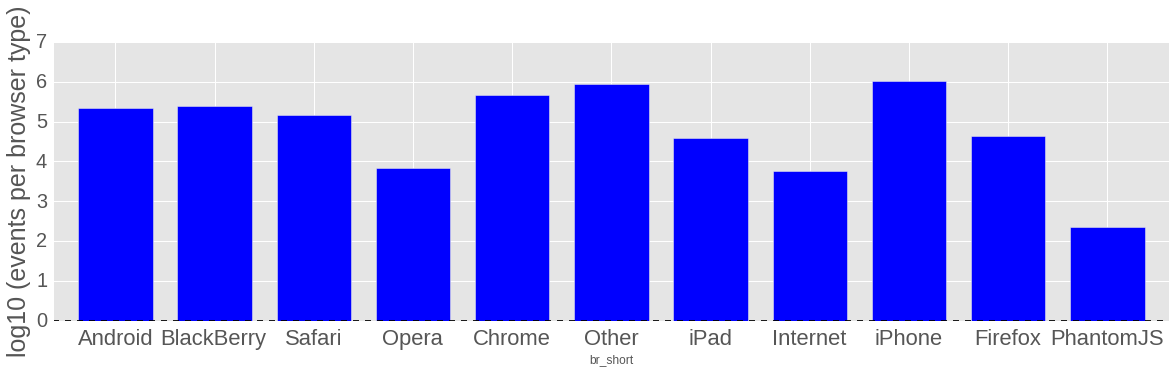

In [377]:
br_counts = data2.groupby('br_short').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate))
plt.figure(figsize=(20,5))
p = np.log10(br_counts[br_ctr.index]).plot(kind='bar',color='b')
p.set_ylabel('log10 (events per browser type)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='horizontal', fontsize=22)
plt.setp(p.get_yticklabels(), fontsize=20)
#plt.gca().invert_yaxis()
fig = p.get_figure()
fig.savefig('../fig/20150615_et_by_br_sort_corrected.png',format='png')

In [69]:
check_br = data2.groupby('br_short').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum()))
check_br.sort(ascending = False)
pd.DataFrame({'ctr':check_br,'cnt':data2['br_short'].value_counts()})

,cnt,ctr
Android,2353,0.006228
BlackBerry,2257,0.004710
Chrome,3010,0.002371
Firefox,192,0.000116
Internet,28,0.000520
Opera,52,0.003168
Other,4784,0.001195
PhantomJS,1,0.000000
Safari,1156,0.003494
iPad,191,0.000682


#How to explain the difference in browser and location?

First I want to examine the difference in each app systematically:

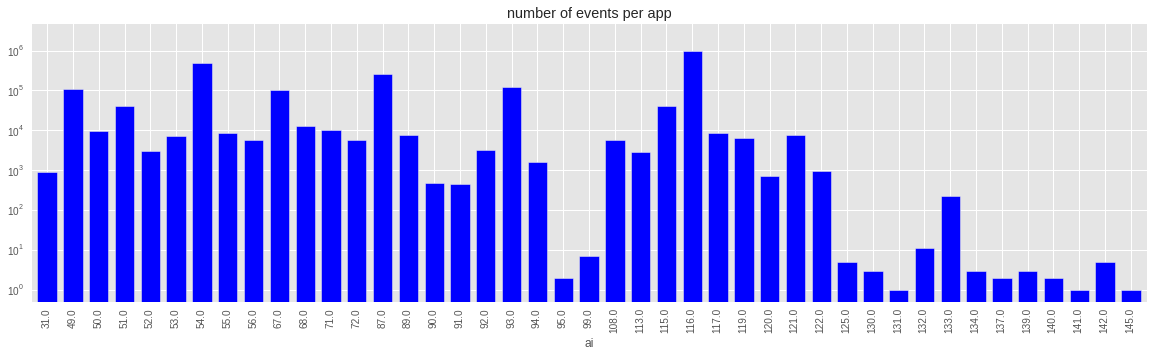

In [397]:
plt.figure(figsize=(20,5))
p = data2.groupby('ai').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate)).plot(kind='bar',color='b',ylim=(.5,5000000),title='number of events per app')
p.set_yscale('log')

DC: 67/68 TM: 53/54 are the ones with more events

High CTR: 67,87,93

Low CTR: 49,51,54,115,116

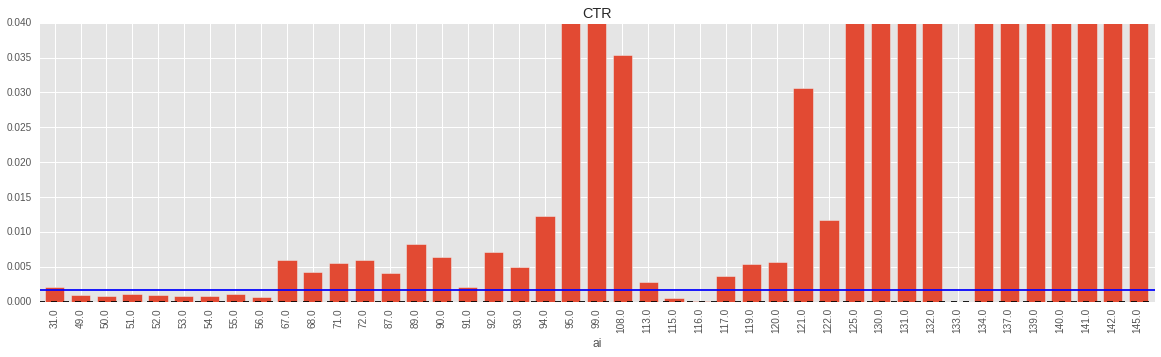

In [395]:
plt.figure(figsize=(20,5))
p = data2.groupby('ai').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,.04),title='CTR')
plt.axhline(y=rate)

I want to calculate the proportion of each type of browser for each app

In [94]:
aid = 89
check_ai_br = data2[data2['ai'] == aid].groupby('br_short').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum()))
check_ai_br.sort(ascending = False)
pd.DataFrame({'ctr':check_ai_br,'cnt':data2[data2['ai'] == aid]['br_short'].value_counts()})

,cnt,ctr
Android,9,0.008594
BlackBerry,47,0.004901
Chrome,8,0.007172
Firefox,1,1.000000
Other,13,1.000000
Safari,18,0.011143


In [79]:
aid = 68
check_co_br = data2[data2['ai'] == aid].groupby('co').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum()))
check_co_br.sort(ascending = False)
pd.DataFrame({'ctr':check_co_br,'cnt':data2[data2['ai'] == aid]['co'].value_counts()})

,cnt,ctr
DEU,3,0.002162
GBR,3,0.008594
ITA,88,0.003438
USA,14,0.025346


My questions:

I wonder why some apps/ads are better than the others?...

Any good paring for ads/apps?

# Correlation between browser and location?

In [77]:
co = 'NGA'
check_cor = data2[data2['co'] == co].groupby('br_short').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum()))
check_cor.sort(ascending = False)
pd.DataFrame({'ctr':check_cor,'cnt':data2[data2['co'] == co]['br_short'].value_counts()})

,cnt,ctr
Android,396,0.009202
BlackBerry,56,0.007741
Chrome,354,0.004996
Firefox,61,0.000224
Internet,2,1.000000
Opera,39,0.002702
Other,44,0.002992
Safari,945,0.004234
iPad,18,0.004315
iPhone,109,0.006126


Seem to be somehow correlated...

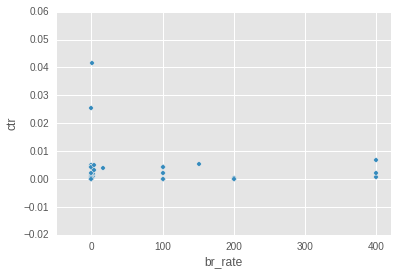

In [91]:
co_ctr = data2.groupby('co').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum()))
co_anroid_iphone = data2.groupby('co').apply(lambda x:float(x[x['br_short'] == 'Android'].shape[0])/(x[x['br_short'] == 'iPhone'].shape[0] + 0.01))
pd.DataFrame({'ctr':co_ctr,'br_rate':co_anroid_iphone}).plot(kind='scatter',x='br_rate',y='ctr',ylim=(-.02,.06),xlim=(-50,420))

No they are not correclated across all countries...

What to look at it in a different way:

#Timestamp - local or same time zone?

In [32]:
clicks_uniq['created_at']

0     2015-05-10T04:41:11.915Z
1     2015-05-10T20:52:50.992Z
2     2015-05-12T17:55:12.568Z
3     2015-05-12T18:02:23.940Z
4     2015-05-12T14:14:23.627Z
5     2015-05-12T22:16:44.314Z
6     2015-04-13T15:49:41.933Z
7     2015-05-12T18:03:20.597Z
8     2015-05-12T08:40:42.916Z
9     2015-05-12T16:48:23.384Z
10    2015-05-12T23:36:58.860Z
11    2015-05-12T20:36:14.506Z
12    2015-04-13T10:26:40.235Z
13    2015-05-14T07:41:26.525Z
14    2015-05-14T08:16:30.860Z
...
9143    2014-12-19T00:37:52.258Z
9144    2014-12-19T00:35:50.039Z
9145    2014-12-19T20:40:30.128Z
9146    2014-12-18T18:12:51.604Z
9147    2014-12-19T00:53:27.426Z
9148    2014-12-19T00:38:26.027Z
9149    2014-12-19T09:52:37.228Z
9150    2014-12-19T14:05:12.844Z
9151    2014-12-19T07:35:39.403Z
9152    2014-12-19T17:00:49.196Z
9153    2014-12-18T16:45:02.435Z
9154    2014-12-18T23:53:13.589Z
9155    2014-11-18T02:49:17.500Z
9156    2014-11-18T05:24:14.830Z
9157    2014-11-04T21:18:23.998Z
Name: created_at, Length: 9158, dtyp

In [81]:
data2[data2['br_short'] == 'Android'].shape[0]

2353

#CTR on different ads and app pairs

I have looked at that CTR varies across all apps. How about ads?

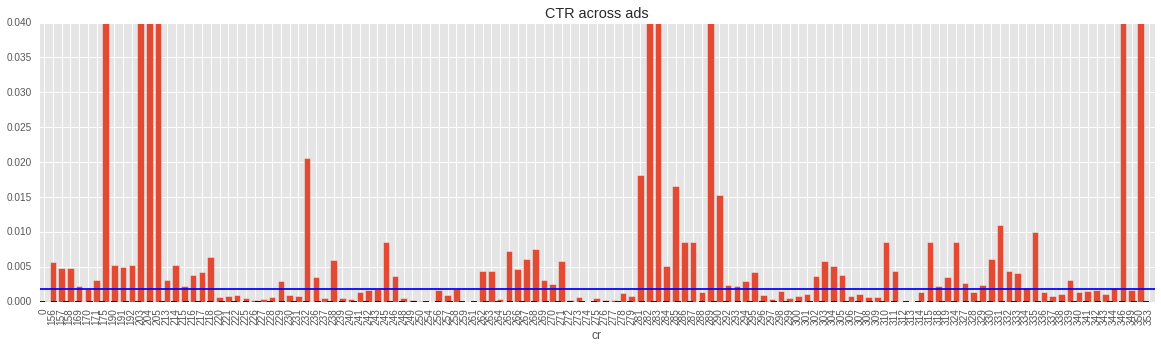

In [98]:
plt.figure(figsize=(20,5))
p = data2.groupby('cr').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,.04),title='CTR across ads')
plt.axhline(y=rate)

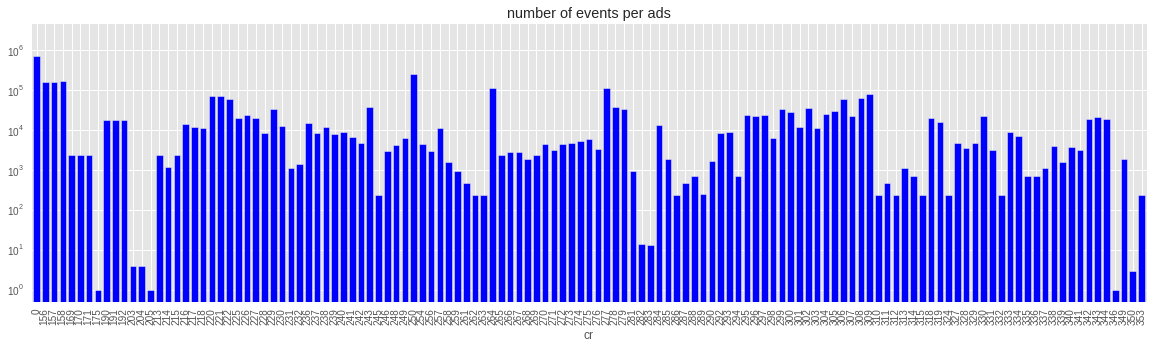

In [99]:
plt.figure(figsize=(20,5))
p = data2.groupby('cr').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate)).plot(kind='bar',color='b',ylim=(.5,5000000),title='number of events per ads')
p.set_yscale('log')

For a given ad, how different app differ in CTR?

Super targeted (1 app): 214, 285, 289, 290

<= 5 app: 250, 256, 275

Diverse:

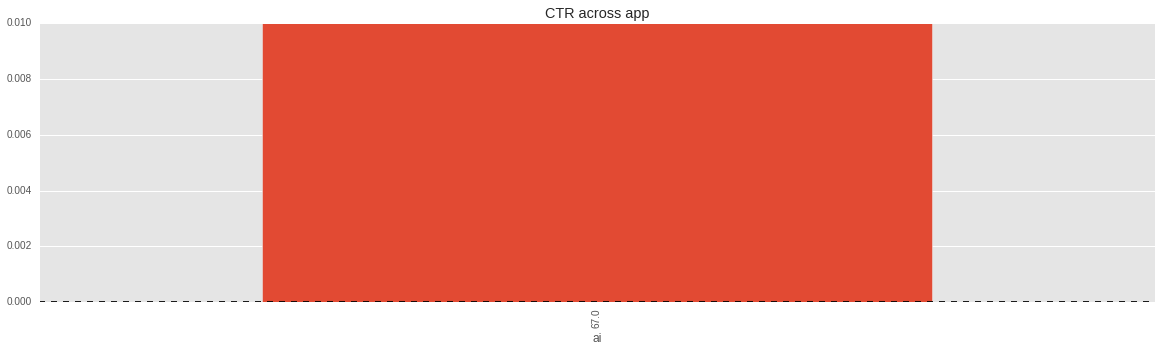

In [163]:
cr = 289
plt.figure(figsize=(20,5))
p = data2[data2['cr'] == cr].groupby('ai').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,0.01),title='CTR across app')

Number of apps per ads:

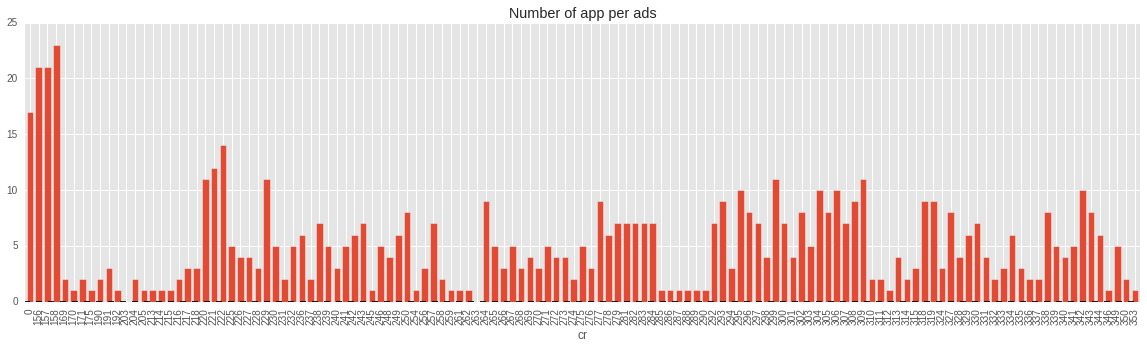

In [159]:
plt.figure(figsize=(20,5))
data2.groupby('cr').apply(lambda x: len(np.unique(x['ai'].dropna()))).sort_index().plot(kind='bar',title='Number of app per ads')

For a given app, how different ads differ in CTR?

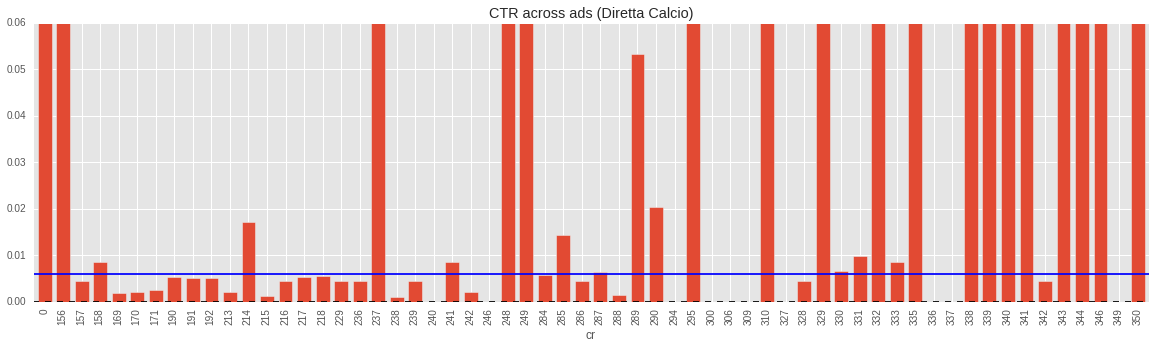

In [121]:
plt.figure(figsize=(20,5))
p = data2_Diretta_Calcio.groupby('cr').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,.06),title='CTR across ads (Diretta Calcio)')
plt.axhline(y=rate_Diretta_Calcio)

Good ads for DC: (158), 214, (241), 285, 289, 290, (331, 333)

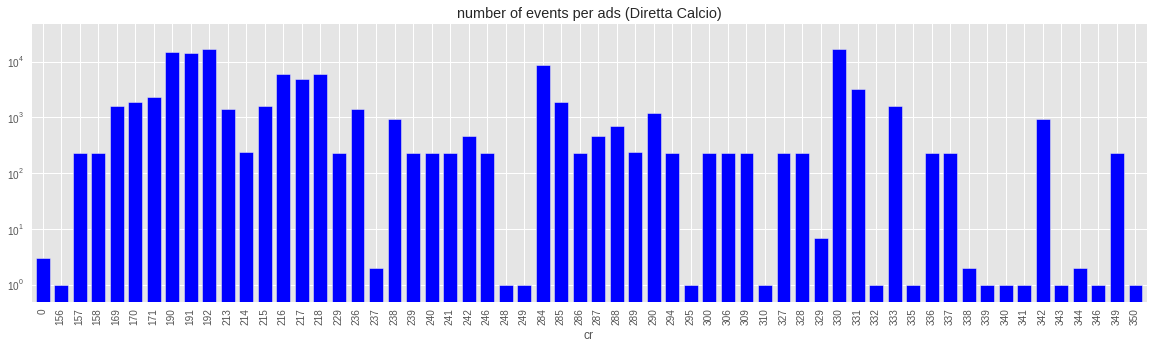

In [127]:
plt.figure(figsize=(20,5))
p = data2_Diretta_Calcio.groupby('cr').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate)).plot(kind='bar',color='b',ylim=(.5,50000),title='number of events per ads (Diretta Calcio)')
p.set_yscale('log')

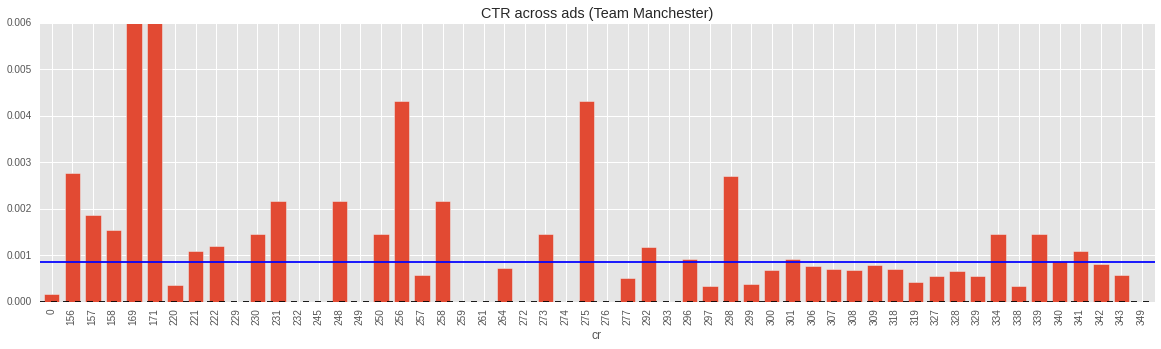

In [132]:
plt.figure(figsize=(20,5))
p = data2_Team_Manchester.groupby('cr').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,.006),title='CTR across ads (Team Manchester)')
plt.axhline(y=rate_Team_Manchester)

Good ads for TM: 156, 256, 275, 298

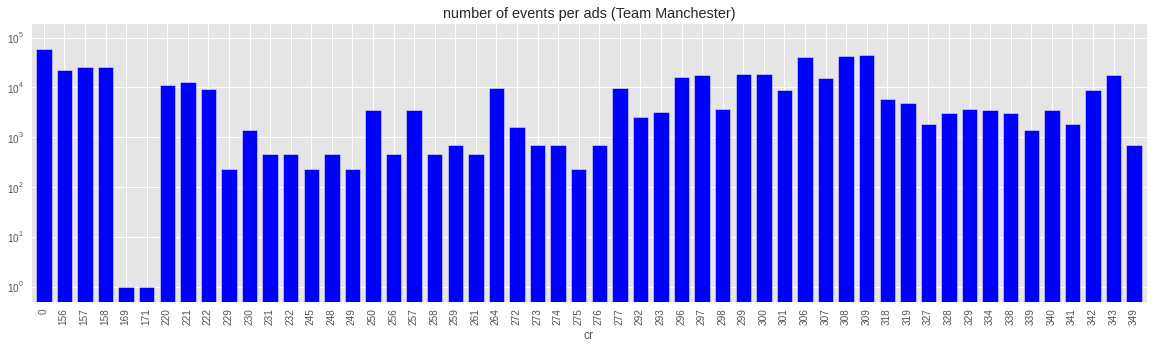

In [130]:
plt.figure(figsize=(20,5))
p = data2_Team_Manchester.groupby('cr').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate)).plot(kind='bar',color='b',ylim=(.5,200000),title='number of events per ads (Team Manchester)')
p.set_yscale('log')

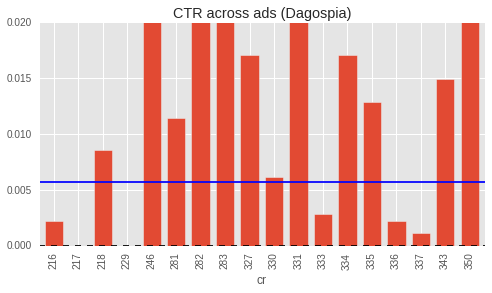

In [137]:
plt.figure(figsize=(8,4))
p = data2_Dagospia.groupby('cr').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,.02),title='CTR across ads (Dagospia)')
plt.axhline(y=rate_Dagospia)

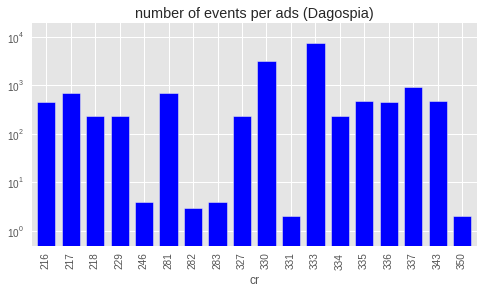

In [139]:
plt.figure(figsize=(8,4))
p = data2_Dagospia.groupby('cr').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate)).plot(kind='bar',color='b',ylim=(.5,20000),title='number of events per ads (Dagospia)')
p.set_yscale('log')

In [156]:
len(np.unique(data2[data2['cr'] == 275]['ai'].dropna()))

5

#Full-scale ads and app "interaction"

Get raw data directly from the elastic database:

In [161]:
res = requests.get('http://elasticsearch-events.fal.zenit.io:9200/',auth=(eslogin.user,eslogin.password))
print(res.content)

{
  "status" : 200,
  "name" : "es02.fal.zenit.io",
  "cluster_name" : "zenit-events",
  "version" : {
    "number" : "1.5.2",
    "build_hash" : "62ff9868b4c8a0c45860bebb259e21980778ab1c",
    "build_timestamp" : "2015-04-27T09:21:06Z",
    "build_snapshot" : false,
    "lucene_version" : "4.10.4"
  },
  "tagline" : "You Know, for Search"
}



In [162]:
es = Elasticsearch([{'host': 'elasticsearch-events.fal.zenit.io', 'port': 9200}],http_auth=('zenit','6nAzJGhq'))

Test

In [167]:
es.count(index="events-2015.05.*", body={'query': {'bool': {'must':[{'match': { 'ai' : 67 }}, {'match': { 'cr' : 289 }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

1048

In [176]:
columns = [53,54,67,68,71,72]
index = [156, 256, 275, 298, 214, 285, 289, 290]
df_test = pd.DataFrame(index=index, columns=columns)
df_test = df_test.fillna(0)
df_test

,53,54,67,68,71,72
156,0,0,0,0,0,0
256,0,0,0,0,0,0
275,0,0,0,0,0,0
298,0,0,0,0,0,0
214,0,0,0,0,0,0
285,0,0,0,0,0,0
289,0,0,0,0,0,0
290,0,0,0,0,0,0


In [177]:
for col in columns:
    for ind in index:
        df_test.loc[ind,col] = es.count(index="events-2015.05.*", body={'query': {'bool': {'must':[{'match': { 'ai' : col }}, {'match': { 'cr' : ind }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

In [178]:
df_test

,53,54,67,68,71,72
156,585,41948,51,53,0,0
256,13,1734,5,0,0,0
275,11,787,0,0,0,0
298,74,5999,0,0,0,0
214,0,67,0,1989,0,0
285,0,0,2257,0,0,0
289,0,0,1048,0,0,0
290,0,0,1435,0,0,0
